In [164]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt




In [120]:
myData = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
#data cleaning
myData = myData.dropna()
myData.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [121]:
X_no_thalach = X.drop(columns="thalach")
X_no_ecg = X.drop(columns="restecg")
X_no_age = X.drop(columns="age")
X_no_sex = X.drop(columns="sex")
X_no_cp = X.drop(columns="cp")
X_no_trtbps = X.drop(columns="trtbps")
X_no_chol = X.drop(columns="chol")

# Part One: Fitting Models

##### Q1: KNN

In [122]:
datasets = {
    "full": (X),
    "no_thalach": (X_no_thalach),
    "no_ecg": (X_no_ecg),
    "no_age": (X_no_age),
    "no_sex": (X_no_sex),
    "no_cp": (X_no_cp),
    "no_trtbps": (X_no_trtbps),
    "no_chol": (X_no_chol)
}

In [123]:
ct_knn = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")


In [124]:
knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform="pandas")

params = {'knn__n_neighbors': list(range(1, 100))}

for dataset_name, X_data in datasets.items():
    grid_search = GridSearchCV(
        knn_pipeline1,
        params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_data, y)
    
    best_n_neighbors = grid_search.best_params_['knn__n_neighbors']
    best_roc_auc = grid_search.best_score_
    
    print(dataset_name)
    print(f"param {best_n_neighbors}")
    print(f"ROC AUC {best_roc_auc}")
    print()


full
param 54
ROC AUC 0.850684350132626

no_thalach
param 46
ROC AUC 0.8205227232537577

no_ecg
param 37
ROC AUC 0.8550118479221928

no_age
param 60
ROC AUC 0.8425414677276745

no_sex
param 80
ROC AUC 0.8011671087533155

no_cp
param 64
ROC AUC 0.8004166224580018

no_trtbps
param 24
ROC AUC 0.8433807250221044

no_chol
param 44
ROC AUC 0.8597704686118479



In [125]:
knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier(n_neighbors=44))
    ]
).set_output(transform="pandas")

In [126]:
knn_pipeline1.fit(X_no_chol, y)
y_pred_knn = knn_pipeline1.predict(X_no_chol)
conf_matrix = confusion_matrix(y, y_pred_knn)
class_names = ["not at risk", "at risk"]
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_df

,not at risk,at risk
not at risk,91,36
at risk,25,121


##### Q2: Logistic Regression

In [127]:
log_reg_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("log_reg", LogisticRegression())
    ]
).set_output(transform="pandas")

params = {'log_reg__C': [0.01, 0.1, 1, 10, 100]}

for dataset_name, X_data in datasets.items():
    grid_search = GridSearchCV(
        log_reg_pipeline,
        params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_data, y)
    
    best_C = grid_search.best_params_['log_reg__C']
    best_roc_auc = grid_search.best_score_
    
    print(dataset_name)
    print(f"param {best_C}")
    print(f"ROC AUC {best_roc_auc}")
    print()


full
param 0.01
ROC AUC 0.8546433244916003

no_thalach
param 0.1
ROC AUC 0.8210496905393458

no_ecg
param 10
ROC AUC 0.8590076038903625

no_age
param 10
ROC AUC 0.855751724137931

no_sex
param 0.01
ROC AUC 0.7979402298850575

no_cp
param 1
ROC AUC 0.8072106100795755

no_trtbps
param 1
ROC AUC 0.8480778072502211

no_chol
param 0.01
ROC AUC 0.851977365163572



In [128]:
log_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("log", LogisticRegression(C=10))
    ]
).set_output(transform="pandas")


In [129]:
log_pipeline.fit(X_no_ecg, y)
y_pred_log = log_pipeline.predict(X_no_ecg)
conf_matrix = confusion_matrix(y, y_pred_log)
class_names = ["not at risk", "at risk"]
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_df

,not at risk,at risk
not at risk,96,31
at risk,24,122


In [163]:
log_pipeline.named_steps['log'].coef_
names = X_no_ecg.columns
coef_df = pd.DataFrame(coefficients.T, index=names)
coef_df

,0
age,-0.244286
sex,-1.012605
cp,0.887842
trtbps,-0.419467
chol,-0.310066
thalach,0.917448


##### Q3: Decision Tree

In [130]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("dt", DecisionTreeClassifier())
    ]
).set_output(transform="pandas")

params = {'dt__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

for dataset_name, X_data in datasets.items():
    grid_search = GridSearchCV(
        dt_pipeline,
        params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_data, y)
    
    best_min_impurity_decrease = grid_search.best_params_['dt__min_impurity_decrease']
    best_roc_auc = grid_search.best_score_
    
    print(dataset_name)
    print(f"param {best_min_impurity_decrease}")
    print(f"ROC AUC {best_roc_auc}")
    print()


full
param 0.01
ROC AUC 0.7673043324491601

no_thalach
param 0.01
ROC AUC 0.7760576480990274

no_ecg
param 0.01
ROC AUC 0.7673043324491601

no_age
param 0.01
ROC AUC 0.7538072502210433

no_sex
param 0.01
ROC AUC 0.7662627763041556

no_cp
param 0.01
ROC AUC 0.728881343943413

no_trtbps
param 0.01
ROC AUC 0.780654288240495

no_chol
param 0.01
ROC AUC 0.7542100795755967



In [131]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("dt", DecisionTreeClassifier(min_impurity_decrease=0.01))  
    ]
).set_output(transform="pandas")


In [132]:
dt_pipeline.fit(X_no_thalach, y)
y_pred_tree = dt_pipeline.predict(X_no_thalach)
conf_matrix = confusion_matrix(y, y_pred_tree)
class_names = ["not at risk", "at risk"]
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_df

,not at risk,at risk
not at risk,98,29
at risk,20,126


<Figure size 2000x1000 with 0 Axes>

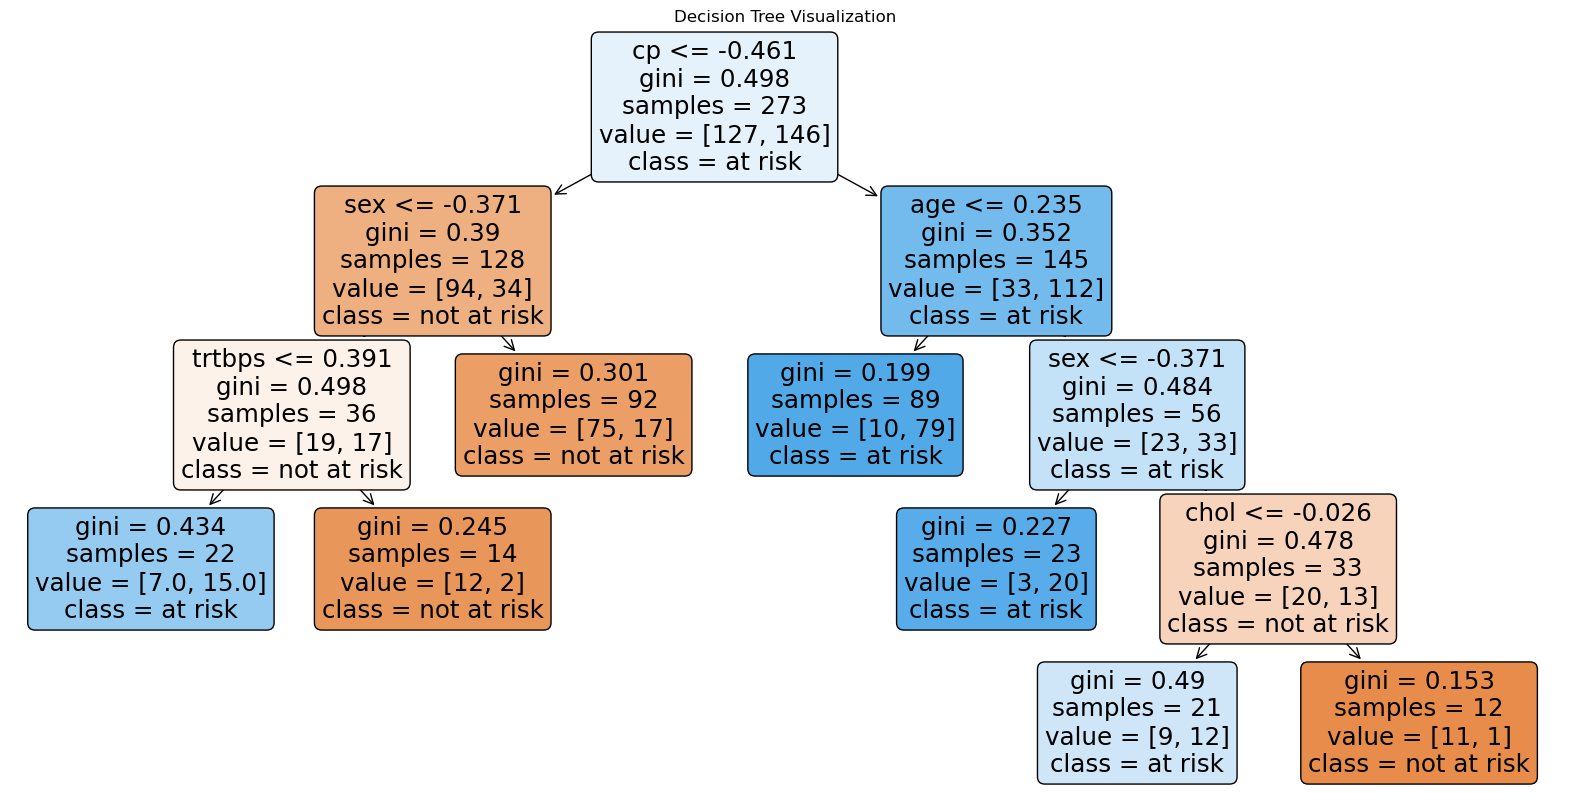

In [166]:
plt.figure(figsize=(20, 10))
plot_tree(dt_pipeline.named_steps['dt'], filled=True, feature_names=X_no_thalach.columns, class_names=['not at risk', 'at risk'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

##### Q4: Interpretation

##### Q5: ROC Curve

##### KNN

In [133]:
fpr, tpr, thresholds = roc_curve(y, y_pred_knn)
roc = pd.DataFrame({'False Positive Rate': fpr,'True Positive Rate': tpr,'Threshold': thresholds})

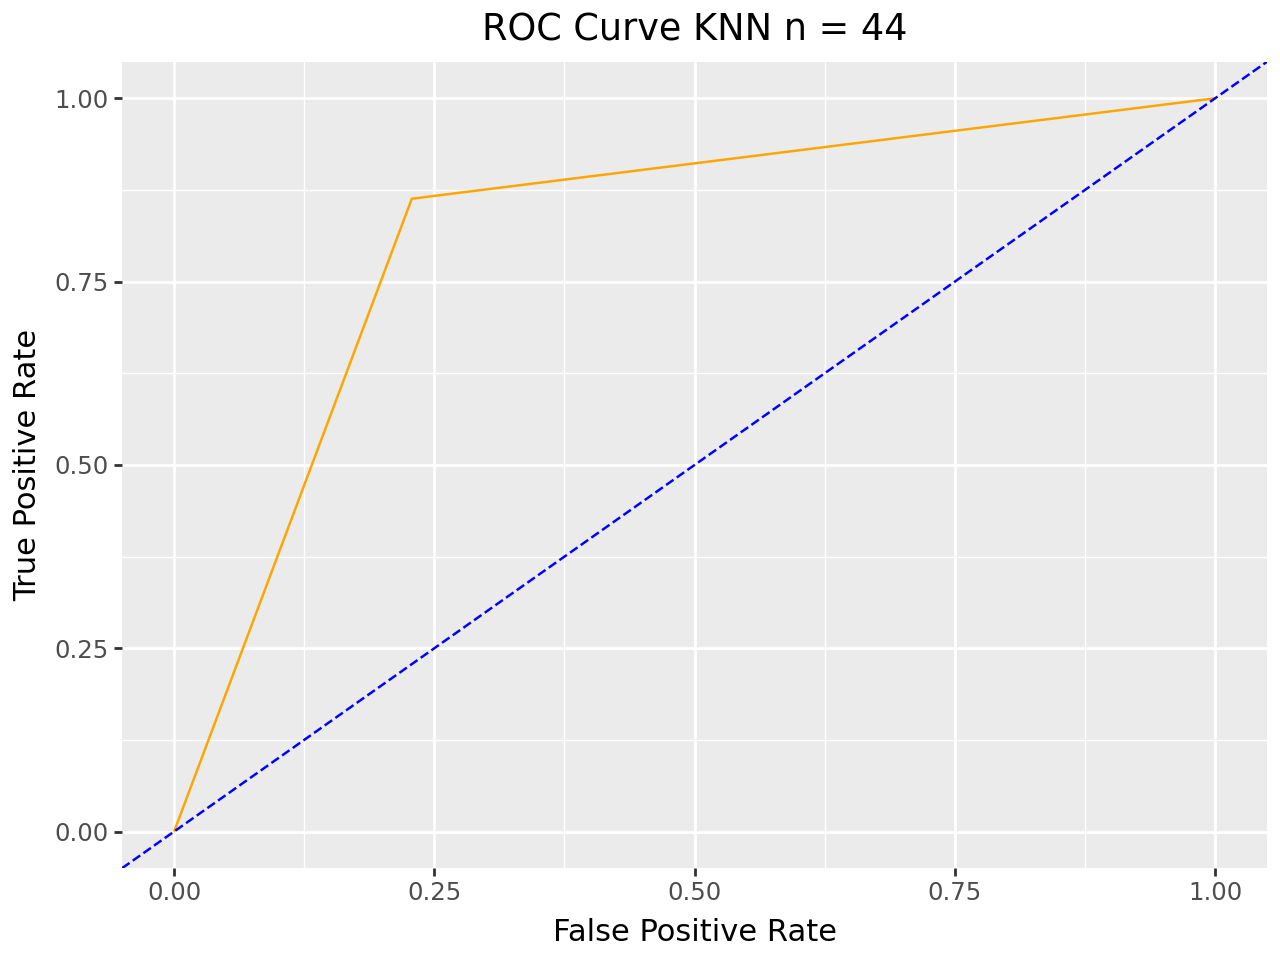

In [146]:
(ggplot(roc, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='orange') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='blue') +
    labs(
        title='ROC Curve KNN n = 44',
        x='False Positive Rate',
        y='True Positive Rate'
    )
)

##### Logistic Regression

In [147]:
fpr, tpr, thresholds = roc_curve(y, y_pred_log)
roc = pd.DataFrame({'False Positive Rate': fpr,'True Positive Rate': tpr,'Threshold': thresholds})

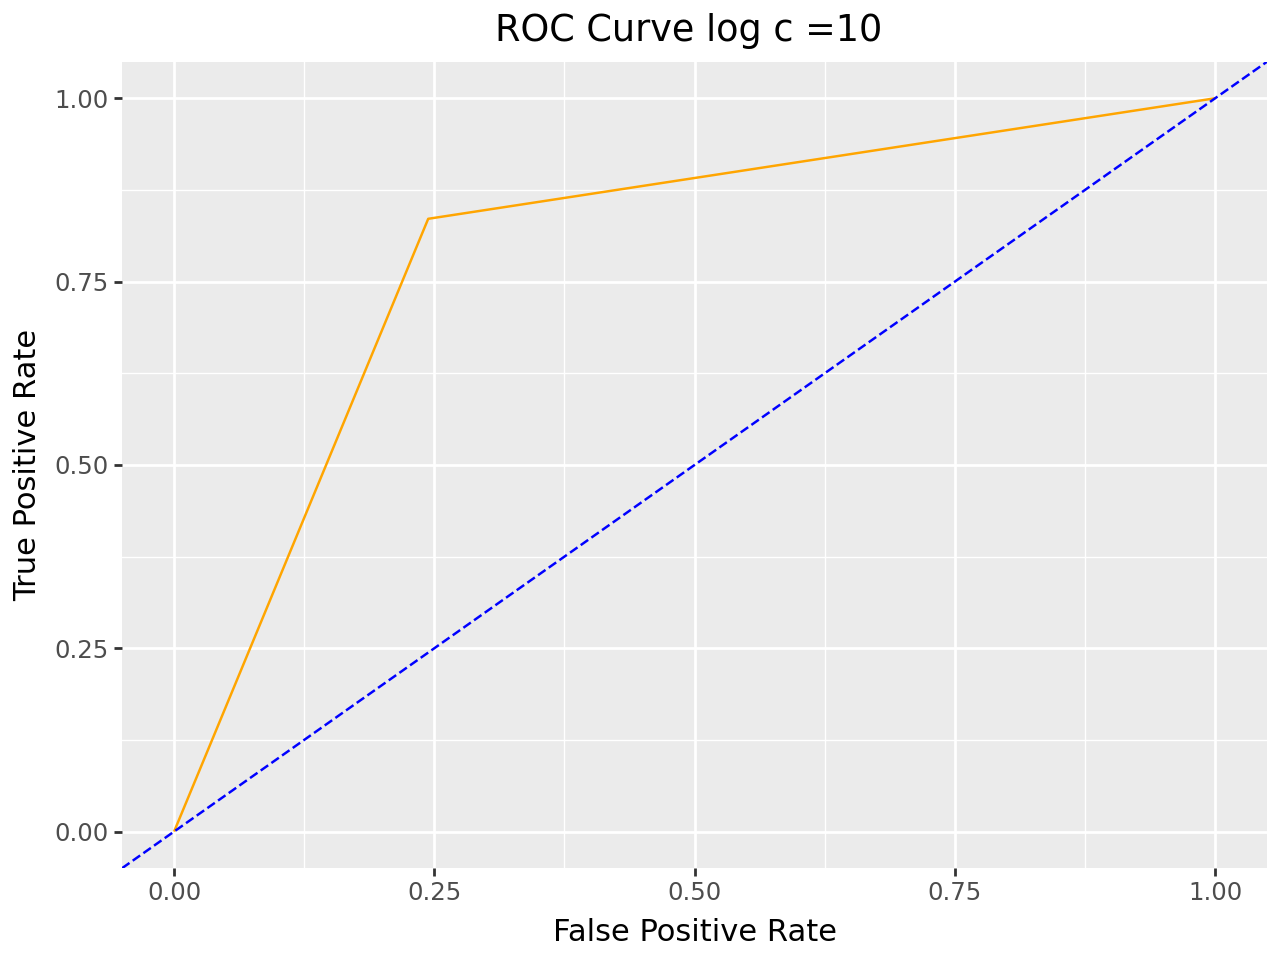

In [148]:
(ggplot(roc, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='orange') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='blue') +
    labs(
        title='ROC Curve log c =10 ',
        x='False Positive Rate',
        y='True Positive Rate'
    )
)

##### Decision Tree

In [149]:
fpr, tpr, thresholds = roc_curve(y, y_pred_tree)
roc = pd.DataFrame({'False Positive Rate': fpr,'True Positive Rate': tpr,'Threshold': thresholds})

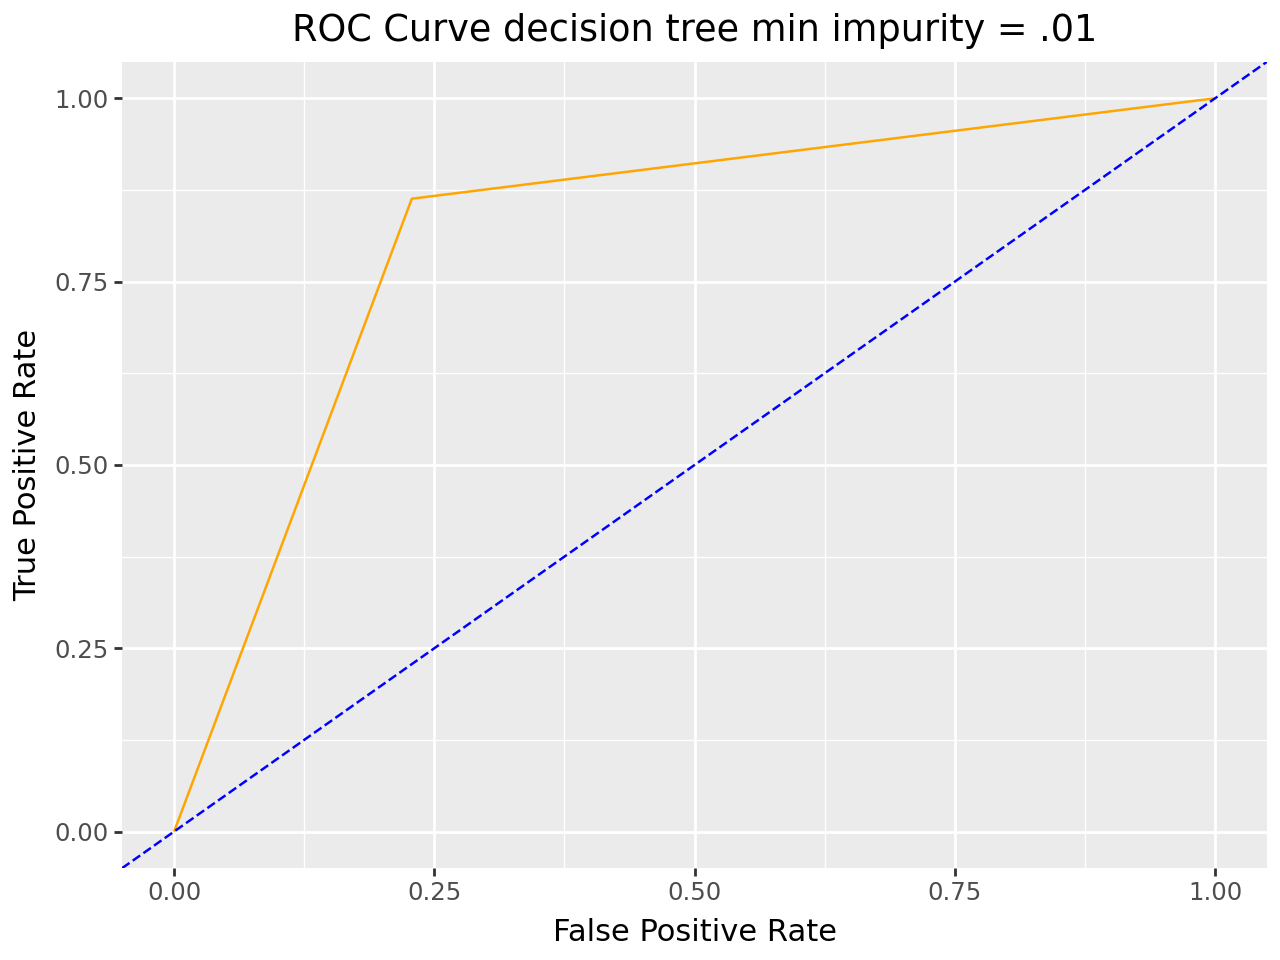

In [150]:
(ggplot(roc, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='orange') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='blue') +
    labs(
        title='ROC Curve decision tree min impurity = .01',
        x='False Positive Rate',
        y='True Positive Rate'
    )
)

# Part Two: Metrics

##### KNN Metrics

##### Logistic Regression Metrics

##### Decision Tree Metrics

# Part Three: Discussion

##### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack

##### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk

##### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk

##### Q4: the hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by thr algorithm to measure the ability of new doctors to diagnose patients 

# Part Four: Validation

In [151]:
valData = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

##### KNN Validation

##### Logistic Regression Validation

##### Decision Tree Validation

# Part Five: Chohen's Kappa

#### extra code pls ignore

In [152]:
ct_knn = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ]
).set_output(transform="pandas")

In [153]:
knn_pipeline1.fit(X_train, y_train)
y_pred_proba = knn_pipeline1.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)


0.8737373737373738

In [154]:
knn_pipeline1.fit(X_train, y_train)
y_pred_proba_full = knn_pipeline1.predict_proba(X_test)[:, 1]
roc_auc_full = roc_auc_score(y_test, y_pred_proba_full)
print(roc_auc_full)

knn_pipeline1.fit(X_train_no_thalach, y_train)
y_pred_proba_no_thalach = knn_pipeline1.predict_proba(X_test_no_thalach)[:, 1]
roc_auc_no_thalach = roc_auc_score(y_test, y_pred_proba_no_thalach)
print(roc_auc_no_thalach)

knn_pipeline1.fit(X_train_no_ecg, y_train)
y_pred_proba_no_ecg = knn_pipeline1.predict_proba(X_test_no_ecg)[:, 1]
roc_auc_no_ecg = roc_auc_score(y_test, y_pred_proba_no_ecg)
print(roc_auc_no_ecg)

knn_pipeline1.fit(X_train_no_age, y_train)
y_pred_proba_no_age = knn_pipeline1.predict_proba(X_test_no_age)[:, 1]
roc_auc_no_age = roc_auc_score(y_test, y_pred_proba_no_age)
print(roc_auc_no_age)

knn_pipeline1.fit(X_train_no_sex, y_train)
y_pred_proba_no_sex = knn_pipeline1.predict_proba(X_test_no_sex)[:, 1]
roc_auc_no_sex = roc_auc_score(y_test, y_pred_proba_no_sex)
print(roc_auc_no_sex)

knn_pipeline1.fit(X_train_no_cp, y_train)
y_pred_proba_no_cp = knn_pipeline1.predict_proba(X_test_no_cp)[:, 1]
roc_auc_no_cp = roc_auc_score(y_test, y_pred_proba_no_cp)
print(roc_auc_no_cp)

knn_pipeline1.fit(X_train_no_trtbps, y_train)
y_pred_proba_no_trtbps = knn_pipeline1.predict_proba(X_test_no_trtbps)[:, 1]
roc_auc_no_trtbps = roc_auc_score(y_test, y_pred_proba_no_trtbps)
print(roc_auc_no_trtbps)

knn_pipeline1.fit(X_train_no_chol, y_train)
y_pred_proba_no_chol = knn_pipeline1.predict_proba(X_test_no_chol)[:, 1]
roc_auc_no_chol = roc_auc_score(y_test, y_pred_proba_no_chol)
print(roc_auc_no_chol)


0.8737373737373738
0.8446969696969697
0.8615319865319865
0.8632154882154882
0.7861952861952862
0.819023569023569
0.8838383838383838
0.8842592592592593


In [155]:
ct_knn = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform="pandas")

param_grid = {
    'knn__n_neighbors': list(range(1, 100))  
}

grid_search = GridSearchCV(
    knn_pipeline1,
    param_grid,
    cv=5,  
    scoring='roc_auc',  
    n_jobs=-1  
)



In [156]:
grid_search.fit(X_train_no_chol, y_train)
param = grid_search.best_params_['knn__n_neighbors']
score =grid_search.best_score_
print(param,score)

69 0.8452153110047848


In [157]:
X = myData.drop(columns="output")
y = myData["output"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train_no_thalach = X_train.drop(columns="thalach")
X_test_no_thalach = X_test.drop(columns="thalach")
X_train_no_ecg = X_train.drop(columns="restecg")
X_test_no_ecg = X_test.drop(columns="restecg")
X_train_no_age = X_train.drop(columns="age")
X_test_no_age = X_test.drop(columns="age")
X_train_no_sex = X_train.drop(columns="sex")
X_test_no_sex = X_test.drop(columns="sex")
X_train_no_cp = X_train.drop(columns="cp")
X_test_no_cp = X_test.drop(columns="cp")
X_train_no_trtbps = X_train.drop(columns="trtbps")
X_test_no_trtbps = X_test.drop(columns="trtbps")
X_train_no_chol = X_train.drop(columns="chol")
X_test_no_chol = X_test.drop(columns="chol")
